In [4]:
!pip install -qU python-gdcm pydicom pylibjpeg

# Data manipulation and visualization libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import cv2

# File and directory handling libraries
import pydicom
from os import listdir

# Statistical and data processing libraries
from scipy.stats import mode, skew
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# Progress tracking and warning suppression libraries
from tqdm.notebook import trange
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set seaborn style
sns.set_style('darkgrid')

# RSNA BREAST CANCER STAGE 2

In [5]:
! pip install /kaggle/input/gdcm-external-library/python_gdcm-3.0.21-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing /kaggle/input/gdcm-external-library/python_gdcm-3.0.21-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/kaggle/input/gdcm-external-library/python_gdcm-3.0.21-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl'



In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import cv2
from PIL import Image
from tqdm import tqdm
import pydicom
import gdcm
import os
import warnings
warnings.filterwarnings('ignore')

# Importing and preprocessing

In [7]:
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
test = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")
base_img_dir = "/kaggle/input/rsna-breast-cancer-detection/train_images" 

In [8]:
train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [9]:
test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

In [11]:
train.describe()

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id
count,54706.000000,54706.000000,5.470600e+04,54669.000000,54706.000000,54706.000000,54706.000000,26286.000000,54706.000000,54706.000000
mean,1.460407,32698.865262,1.079386e+09,58.543928,0.021168,0.054272,0.014953,0.772350,0.026999,54.618378
std,0.498434,18893.861534,6.183269e+08,10.050884,0.143944,0.226556,0.121365,0.590062,0.162081,44.784800
min,1.000000,5.000000,6.849100e+04,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,1.000000,16481.000000,5.458153e+08,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000
50%,1.000000,32432.000000,1.082689e+09,59.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
75%,2.000000,48999.000000,1.613228e+09,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
max,2.000000,65534.000000,2.147472e+09,89.000000,1.000000,1.000000,1.000000,2.000000,1.000000,216.000000


# Finding the missing values

In [12]:
print(f'Number of values in data: {train.count().sum()}')
print(f'Number missing values in data: {sum(train.isna().sum())}')

Number of values in data: 712191
Number missing values in data: 53693


In [13]:
def find_missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
    return pd.concat([total,percentage] , axis = 1 , keys = ['Total' , 'Percent'])
find_missing_data(train)


,Total,Percent
BIRADS,28420,0.519504
density,25236,0.461302
age,37,0.000676
site_id,0,0.000000
patient_id,0,0.000000
image_id,0,0.000000
laterality,0,0.000000
view,0,0.000000
cancer,0,0.000000
biopsy,0,0.000000


There are missing values only for age, BIRADS and density.

# Covert DICOM -> PNG

In [14]:
import pydicom
import PIL
import matplotlib.pyplot as plt
import glob

img_data  = "/kaggle/input/rsna-breast-cancer-detection"

train_images  = glob.glob(img_data+"/train_images/*/*")

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10706.1.937109986
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10706.1.937109986
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184027.212260'
(0010, 0020) Patient ID                          LO: '10706'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10706
(0020, 000e) Series Instance U

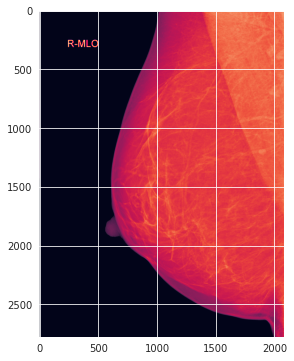

In [15]:
def fun_process(path:str):
    read_dcm = pydicom.dcmread(path)
    print(read_dcm)
    print("\n")
    img = read_dcm.pixel_array
    print(img)
    print("\n", img.shape, "\n")
    img_show = PIL.Image.fromarray(img)
    plt.figure(figsize=(6,6))
    plt.imshow(img_show)
    img_show.save('show1.png')
fun_process(train_images[1])

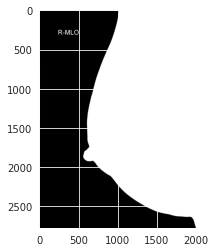

In [16]:
img_show  = PIL.Image.open(r"/kaggle/working/show1.png") 
plt.imshow(img_show)
plt.show()

# Analysis of patient metadata

In [18]:
num_patients = train['patient_id'].nunique()
min_patient_age = int(train['age'].min())
max_patient_age = int(train['age'].max())
groupby_id = train.groupby('patient_id')['cancer'].max()
n_negative = (groupby_id == 0).sum()
n_positive = (groupby_id == 1).sum()

print(f"There are {num_patients} different patients in the train set.\n")
print(f"The younger patient is {min_patient_age} years old.")
print(f"The older patient is {max_patient_age} years old.\n")
print(f"There are {n_negative} patients negative to breast cancer. Ratio = {n_negative / num_patients}")
print(f"There are {n_positive} patients positive to breast cancer. Ratio = {n_positive / num_patients}")

There are 11913 different patients in the train set.

The younger patient is 26 years old.
The older patient is 89 years old.

There are 11427 patients negative to breast cancer. Ratio = 0.9592042306723747
There are 486 patients positive to breast cancer. Ratio = 0.040795769327625284


Of these 11913 patients, roughly 96% had no cancer whereas 4% (486 patients) have cancer. - HIGHLY UNBALANCED

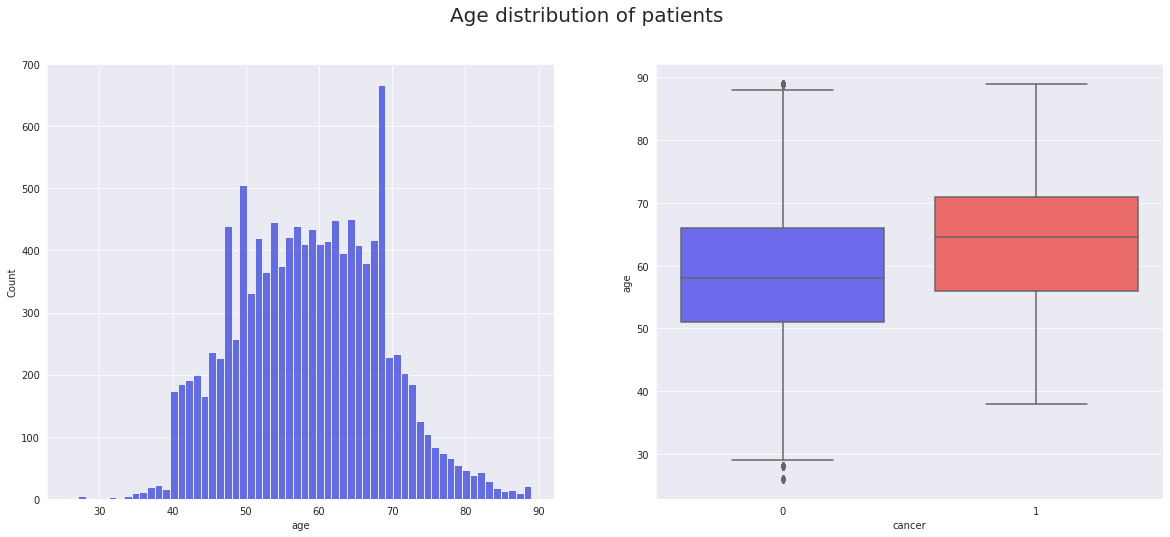

In [19]:
ages = train[train.age.isnull() == False].groupby('patient_id').age.apply(lambda l: np.unique(l)[0])

fig, ax = plt.subplots(1,2 ,figsize=(20,8))


sns.histplot(ages, color='#3642E1', bins=60, ax=ax[0])
sns.boxplot(x = train.cancer, y = train.age, palette='seismic',ax=ax[1])
plt.suptitle('Age distribution of patients', fontsize=20)
plt.show()

Patients with cancer are more likely to be older and between the age group of 60 to 70.
We appear to have two peaks around the ages of 50 and 70.
Beyond the age of 70, the number of patients decreases.

# Age Distribution

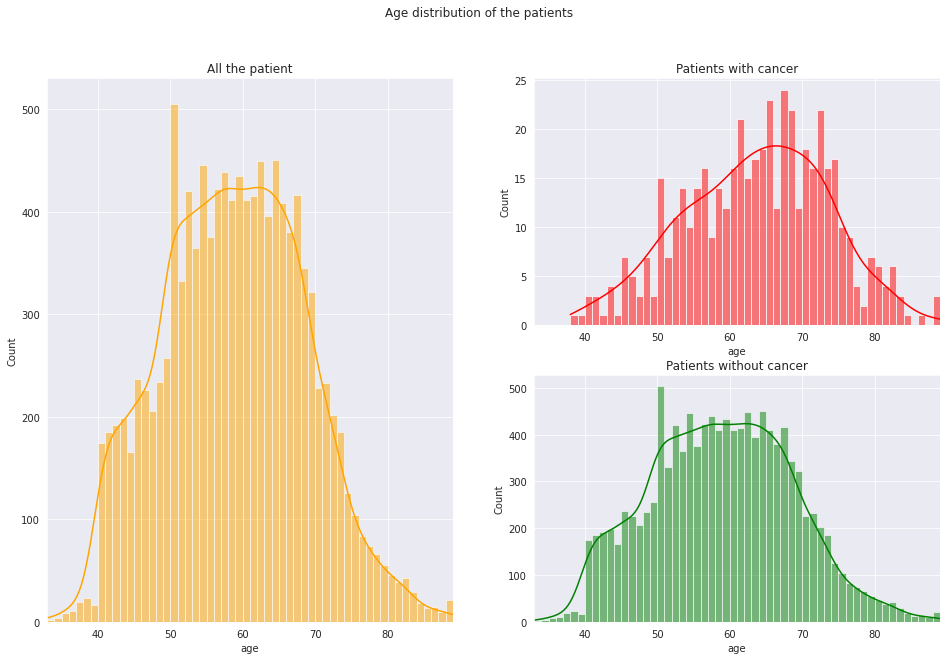

In [21]:
ages = train.groupby('patient_id')['age'].apply(lambda x: x.unique()[0])
cancer_ages = train[train['cancer'] == 1].groupby('patient_id')['age'].apply(lambda x: x.unique()[0])
no_cancer_ages = train[train['cancer'] == 0].groupby('patient_id')['age'].apply(lambda x: x.unique()[0])

plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
sns.histplot(ages, bins=63, color='orange', kde=True)
plt.title("All the patient")
plt.xlim(33, 89)

plt.subplot(2, 2, 2)
sns.histplot(cancer_ages, bins=51, color='red', kde=True)
plt.title("Patients with cancer")
plt.xlim(33, 89)

plt.subplot(2, 2, 4)
sns.histplot(no_cancer_ages, bins=63, color='green', kde=True)
plt.title("Patients without cancer")
plt.xlim(33, 89)

plt.suptitle("Age distribution of the patients")
plt.show()

In [22]:
# Statistics
print("Mean:", ages.mean())
print("Std:", ages.std())
print("Q1:", ages.quantile(0.25))
print("Median:", ages.median())
print("Q3:", ages.quantile(0.75))
print("Mode:", ages.mode()[0])

Mean: 58.63821923561529
Std: 9.885104442511699
Q1: 51.0
Median: 59.0
Q3: 66.0
Mode: 50.0


### Insights
- Most of the patients are **older than 40 years old**
- There is a a **peak at the age of 50**
- Then, there is a **plateau until 70 years old** before the count of patients drops
- **Patients with cancer** are usually **older** than the others
- **Age will be an important feature** for a future model

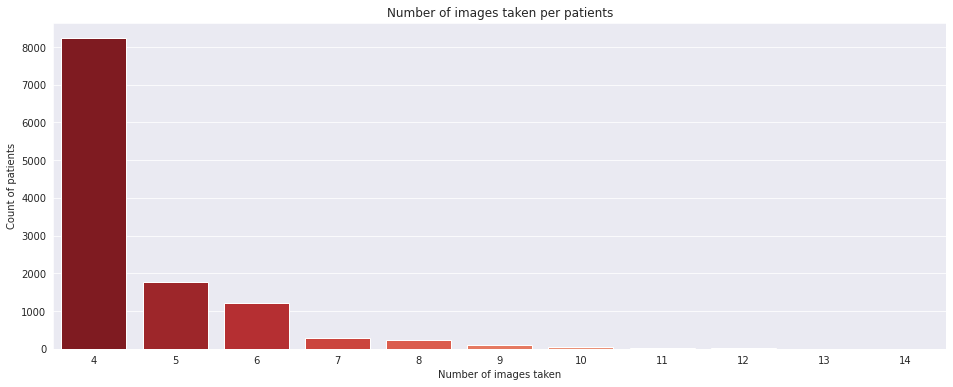

In [24]:
n_images_per_patient = train['patient_id'].value_counts()
plt.figure(figsize=(16, 6))
sns.countplot(n_images_per_patient, palette='Reds_r')
plt.title("Number of images taken per patients")
plt.xlabel('Number of images taken')
plt.ylabel('Count of patients')
plt.show()

* Most of the patients have 4 images (2 views per side). However there are sometimes more of them.

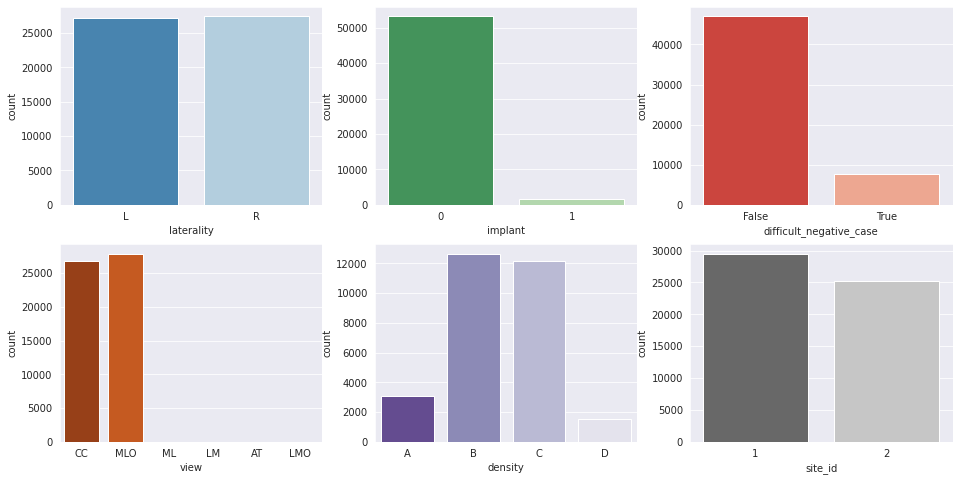

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
sns.countplot(train['laterality'], palette='Blues_r', ax=ax[0, 0])
sns.countplot(train['implant'], palette='Greens_r', ax=ax[0, 1])
sns.countplot(train['difficult_negative_case'], palette='Reds_r', ax=ax[0, 2])
sns.countplot(train['view'], palette='Oranges_r', ax=ax[1, 0])
sns.countplot(train['density'], palette='Purples_r', order=['A', 'B', 'C', 'D'], ax=ax[1, 1])
sns.countplot(train['site_id'], palette='Greys_r', ax=ax[1, 2])
plt.show()

### Insights
* The pictures are balanced in term of laterality
* Only a few images have implents
* Some images were difficult to diagnose
* There are usually only two types of views which are CC and MLO
* There is a minority of images where the breast tissus density is very large (D) or very low (A). Most of the time, the density is in the middle (B) and (C)
* Images where taken in two different sites in a balanced way

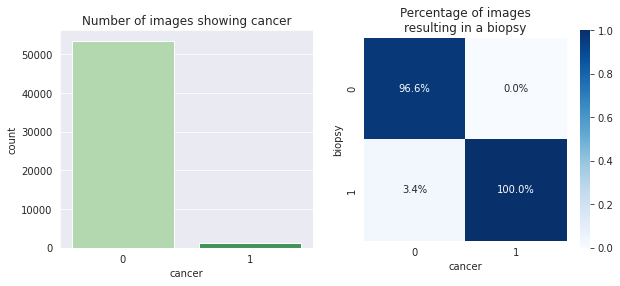

In [28]:
biopsy_counts = train.groupby('cancer')['biopsy'].value_counts().unstack().fillna(0)
biopsy_perc = biopsy_counts.transpose() / biopsy_counts.sum(axis=1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(train['cancer'], palette='Greens', ax=ax[0])
sns.heatmap(biopsy_perc, square=True, annot=True, fmt='.1%', cmap='Blues', ax=ax[1])
ax[0].set_title("Number of images showing cancer")
ax[1].set_title("Percentage of images\nresulting in a biopsy")
plt.show()

### Insights
* The number of sample images with cancer is very low compared to the number of healthy breast samples. It will be more difficult to make the model learn the desired pattern.
* All patients with a cancer had a biopsy
* Only a small percentage of images without cancer resulted in a biopsy

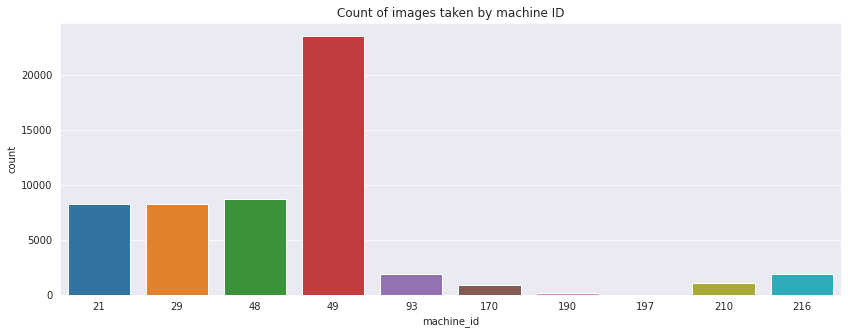

In [29]:
plt.figure(figsize=(14, 5))
sns.countplot(train['machine_id'])
plt.title("Count of images taken by machine ID")
plt.show()

### Insights
* The images were taken from 10 different machines
* Most of the images are from machine 49, 21, 29 and 48
* Machine difference can lead to image distribution difference

# Images showing implantes

In [34]:
m_id_implants = train[train['implant'] == 1]['machine_id'].unique()
print("Scans showing implants are from machines", m_id_implants)

Scans showing implants are from machines [ 49 170]


Cancer was found in very few patients with implants, although quite a few patients without implants had developed the cancer.
Due to a lack of data, we are unable to determine whether implants are related to cancer in any way.
Laterality seems to have no connection to cancer.

### Insights
* All the scans showing implants are from machines 49 and 170.
* The implants are sometimes only present on one side and not in both breasts for a given patient.
* The metadata does not specify the presence of implent for a scan but for a given patient. It is therefore likely that an image without an implant indicates its presence.

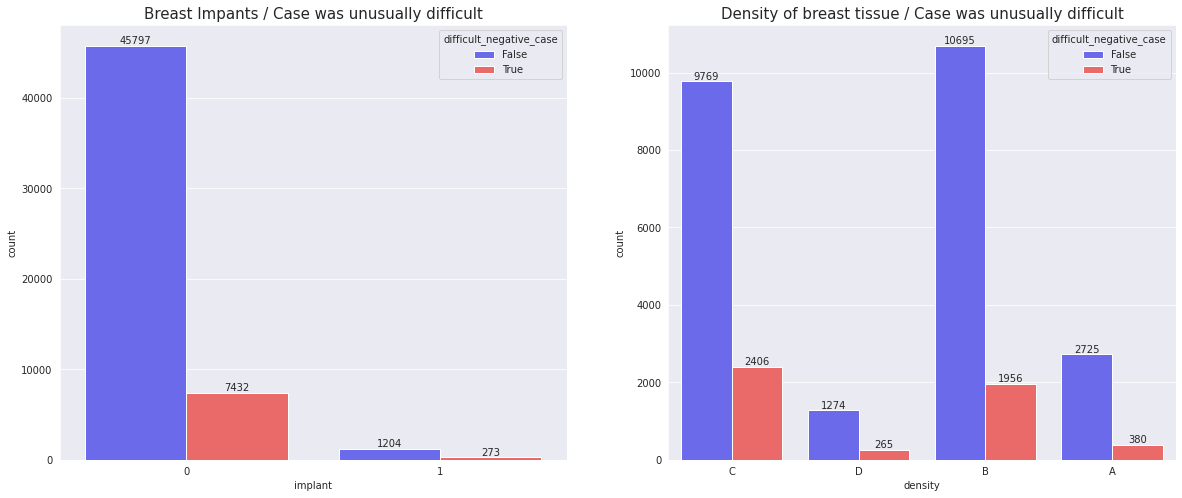

In [40]:
fig, ax = plt.subplots(1,2 ,figsize=(20,8))

sns.countplot(data=train, x="implant", hue="difficult_negative_case", palette='seismic', ax=ax[0]).set_title("Breast Impants / Case was unusually difficult", fontsize=15)

sns.countplot(data=train, x="density", hue="difficult_negative_case", palette='seismic', ax=ax[1]).set_title("Density of breast tissue / Case was unusually difficult", fontsize=15)
for i in range(0,2):
    for container in ax[i].containers:
        ax[i].bar_label(container) 
plt.show()

We cannot determine if breast implants made the process exceptionally difficult due to a lack of data.
# density

* A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
* 
* According to our prior observations, breast density levels of B and C were associated with the highest number of cancer incidences.
* It is stated that Extremely dense tissue can make diagnosis more difficult. it appears that instances with breast densities of B and C made diagnosis challenging.
* Nonetheless, there were relatively few occurrences where the breast density was D as well as lower than A.

# Analysis of image data

In [41]:
def get_image_path(image_df, n):
    ids = image_df[["patient_id", "image_id"]].sample(n, random_state=77)
    paths = []
    for i in range(len(ids)):
        path = os.path.join(base_img_dir, str(ids["patient_id"].values[i]), str(ids["image_id"].values[i])+'.dcm')
        paths.append(path)
    return paths

def image_plot(data_path, title):
    plt.figure(figsize=(15, 8))
    for j in range(n):
        plt.subplot(1, n, j + 1)
        im = pydicom.dcmread(data_path[j])
        plt.imshow(im.pixel_array, cmap='bone')
        plt.grid(False)
        plt.title(title)
        plt.axis("off")
    plt.show()

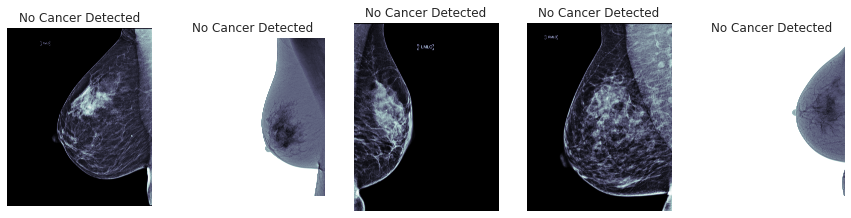

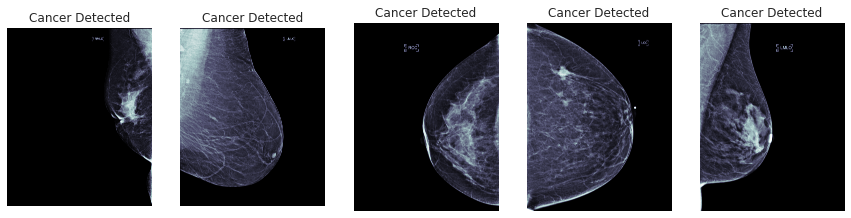

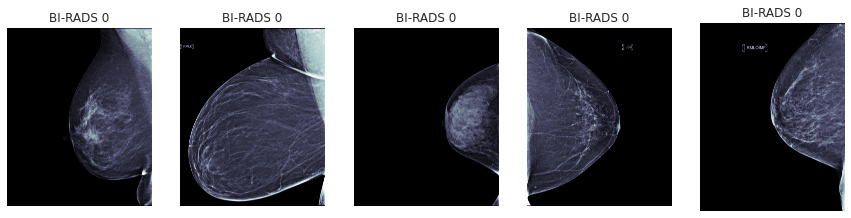

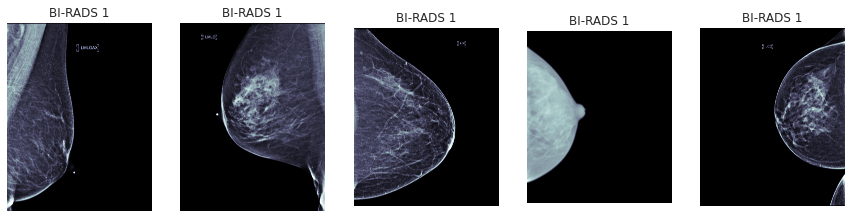

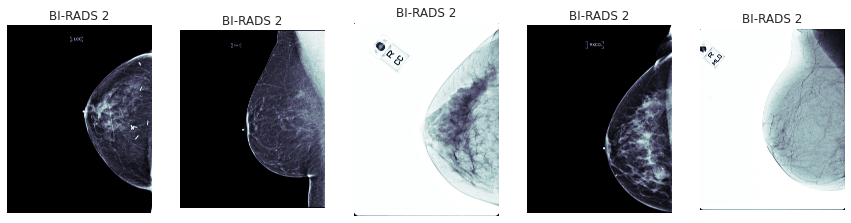

In [42]:
image_no_cancer = train[train["cancer"]==0]
image_cancer = train[train["cancer"]==1]
image_birads0 = train[train["BIRADS"] == 0.0]
image_birads1 = train[train["BIRADS"] == 1.0]
image_birads2 = train[train["BIRADS"] == 2.0]

n = 5
no_cancer_paths = get_image_path(image_no_cancer, n)
cancer_paths = get_image_path(image_cancer, n)
birads0_paths = get_image_path(image_birads0, n)
birads1_paths = get_image_path(image_birads1, n)
birads2_paths = get_image_path(image_birads2, n)

image_plot(no_cancer_paths, "No Cancer Detected")
image_plot(cancer_paths, "Cancer Detected")
image_plot(birads0_paths, "BI-RADS 0")
image_plot(birads1_paths, "BI-RADS 1")
image_plot(birads2_paths, "BI-RADS 2")

 BIRADS value signification:

* 0: required follow-up
* 1: rated as negative for cancer
* 2: rated as normal

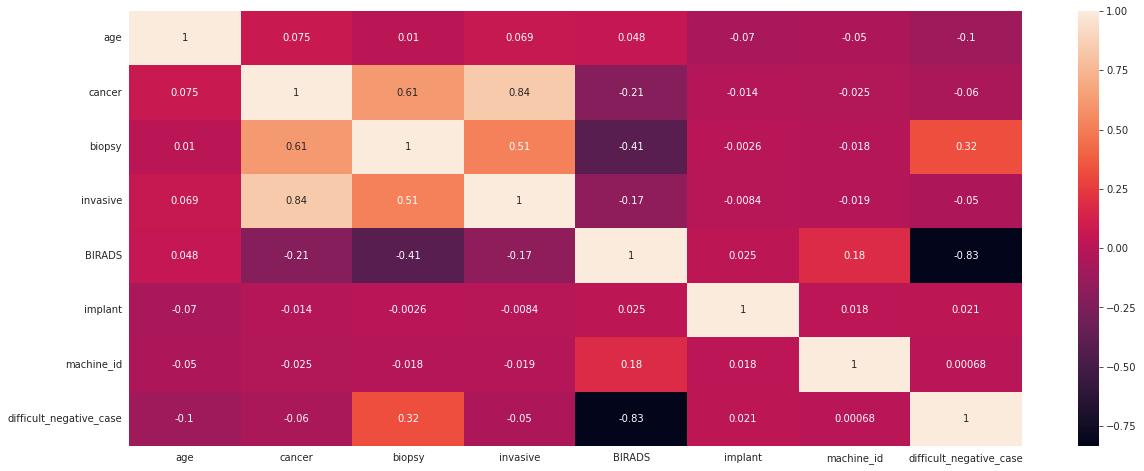

In [44]:
plt.figure(figsize=(20, 8))
sns.heatmap(train.drop(['site_id', 'patient_id','image_id'], axis=1).corr(),annot=True)
plt.show()

In [45]:
from sklearn.preprocessing import LabelEncoder

In [46]:
train_df = train.copy()
y = train_df['cancer']

train_df.drop(['patient_id','image_id','BIRADS','site_id','machine_id','density','difficult_negative_case','cancer','biopsy','invasive'], axis=1, inplace=True)

In [47]:
le=LabelEncoder()
col_list=['laterality','view']
for col in col_list:
    train_df[col]=le.fit_transform(train_df[col])
train_df.head()

,laterality,view,age,implant
0,0,1,61.0,0
1,0,5,61.0,0
2,1,5,61.0,0
3,1,1,61.0,0
4,0,1,55.0,0


In [48]:
find_missing_data(train_df)

,Total,Percent
age,37,0.000676
laterality,0,0.000000
view,0,0.000000
implant,0,0.000000


In [50]:
# Filling the null values with mean value.
train_df['age']=train_df['age'].fillna(train_df['age'].mean())

# Comparing different algorithms

In [51]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_df,y,random_state=777,test_size=0.3)

In [53]:
# Create a dictionary of machine learning algorithms
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

models = {"Logistic regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Linear SVC": LinearSVC(),
          "Random Forest": RandomForestClassifier()}

 # Create a funtion to train (fit) and score models
def train_score(models, X_train, X_test, y_train, y_test):
  # Set random seed
  np.random.seed(0)
  # Make an empty dictionary for model scores
  scores = {}  
  # Loop through models
  for name, model in models.items():
      #Fit the model to the data
      model.fit(X_train, y_train)
      #Evaluate the model and append its score to the scores dictionary
      scores[name] = model.score(X_test, y_test)
  return scores

In [54]:
scores = train_score(models = models,
                   X_train = X_train,
                   X_test = X_test,
                   y_train = y_train,
                   y_test = y_test)

scores

{'Logistic regression': 0.9786132098464538,
 'KNN': 0.9786132098464538,
 'Linear SVC': 0.9786132098464538,
 'Random Forest': 0.9785522788203753}

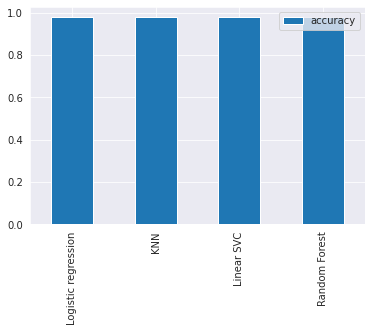

In [55]:
# Model comparison
model_compare = pd.DataFrame(scores, index=["accuracy"])
model_compare.T.plot.bar();

# Conclusion
* The dataset is heavily unbalanced between scans with and without cancer.
* Most of the patients are over 40 years old.
* Images are quite large and will need to be rescaled during preprocessing.
* Pixel distributions vary significantly depending on the machine ID used.
* The dataset is also unbalanced in terms of images showing implants.
* It is very difficult for a novice to distinguish a scan with cancer from a healthy one.

Performing EDA was very informative. It helped me understand what needs to be taken into consideration during the preprocessing steps.

**Thank you for reading. I welcome any feedback you may have. 👋**